Come up with two interesting MDPs. Explain why they are interesting. They don't need to be overly complicated or directly grounded in a real situation, but it will be worthwhile if your MDPs are inspired by some process you are interested in or are familiar with. It's ok to keep it somewhat simple. For the purposes of this assignment, though, make sure one MDP has a "small" number of states, and the other MDP has a "large" number of states. The judgement and rationalization of what is “small” and “large” will be up to you. For initial intuition, 200 states is not considered “large”. Additionally, no more than one of the MDPs you choose should be a grid world problem.

https://github.com/jlm429/bettermdptools/

In [ ]:
!pip3 install bettermdptools

In [ ]:
!pip3 install mdptoolbox-hiive

In [ ]:
!pip install pymdptoolbox

In [ ]:
import gym
import pygame
from algorithms.rl import RL
from examples.test_env import TestEnv
from algorithms.planner import Planner
from gym.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt
from examples.plots import Plots
import math
import pandas as pd
import mdptoolbox, mdptoolbox.example
from gym import wrappers
import time
import sys
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
import gc


## Custom Frozen Lake

In [ ]:
from contextlib import closing
from io import StringIO
from os import path
from typing import List, Optional

import numpy as np

from gym import Env, logger, spaces, utils
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}


# DFS to check that it's a valid path.
def is_valid(board: List[List[str]], max_size: int) -> bool:
    frontier, discovered = [], set()
    frontier.append((0, 0))
    while frontier:
        r, c = frontier.pop()
        if not (r, c) in discovered:
            discovered.add((r, c))
            directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
            for x, y in directions:
                r_new = r + x
                c_new = c + y
                if r_new < 0 or r_new >= max_size or c_new < 0 or c_new >= max_size:
                    continue
                if board[r_new][c_new] == "G":
                    return True
                if board[r_new][c_new] != "H":
                    frontier.append((r_new, c_new))
    return False


def generate_random_map(size: int = 8, p: float = 0.8) -> List[str]:
    """Generates a random valid map (one that has a path from start to goal)

    Args:
        size: size of each side of the grid
        p: probability that a tile is frozen

    Returns:
        A random valid map
    """
    valid = False
    board = []  # initialize to make pyright happy

    while not valid:
        p = min(1, p)
        board = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        board[0][0] = "S"
        board[-1][-1] = "G"
        valid = is_valid(board, size)
    return ["".join(x) for x in board]


class FrozenLakeEnv(Env):
    """
    Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H)
    by walking over the Frozen(F) lake.
    The agent may not always move in the intended direction due to the slippery nature of the frozen lake.


    ### Action Space
    The agent takes a 1-element vector for actions.
    The action space is `(dir)`, where `dir` decides direction to move in which can be:

    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP

    ### Observation Space
    The observation is a value representing the agent's current position as
    current_row * nrows + current_col (where both the row and col start at 0).
    For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
    The number of possible observations is dependent on the size of the map.
    For example, the 4x4 map has 16 possible observations.

    ### Rewards

    Reward schedule:
    - Reach goal(G): +1
    - Reach hole(H): 0
    - Reach frozen(F): 0

    ### Arguments

    ```
    gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    ```

    `desc`: Used to specify custom map for frozen lake. For example,

        desc=["SFFF", "FHFH", "FFFH", "HFFG"].

        A random generated map can be specified by calling the function `generate_random_map`. For example,

        ```
        from gym.envs.toy_text.frozen_lake import generate_random_map

        gym.make('FrozenLake-v1', desc=generate_random_map(size=8))
        ```

    `map_name`: ID to use any of the preloaded maps.

        "4x4":[
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
            ]

        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]

    `is_slippery`: True/False. If True will move in intended direction with
    probability of 1/3 else will move in either perpendicular direction with
    equal probability of 1/3 in both directions.

        For example, if action is left and is_slippery is True, then:
        - P(move left)=1/3
        - P(move up)=1/3
        - P(move down)=1/3

    ### Version History
    * v1: Bug fixes to rewards
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        desc=None,
        map_name="4x4",
        is_slippery=True,
    ):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            terminated = bytes(newletter) in b"GH"
            #reward = float(newletter == b"G")
            if newletter == b"G":
                reward = 5.0
            elif newletter == b"H":
                reward = -2.0
            else:
                reward = -0.05
            return newstate, reward, terminated

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b))
                                )
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

        self.render_mode = render_mode

        # pygame utils
        self.window_size = (min(64 * ncol, 512), min(64 * nrow, 512))
        self.cell_size = (
            self.window_size[0] // self.ncol,
            self.window_size[1] // self.nrow,
        )
        self.window_surface = None
        self.clock = None
        self.hole_img = None
        self.cracked_hole_img = None
        self.ice_img = None
        self.elf_images = None
        self.goal_img = None
        self.start_img = None

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}

    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
        elif self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    def _render_gui(self, mode):
        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        if self.window_surface is None:
            pygame.init()

            if mode == "human":
                pygame.display.init()
                pygame.display.set_caption("Frozen Lake")
                self.window_surface = pygame.display.set_mode(self.window_size)
            elif mode == "rgb_array":
                self.window_surface = pygame.Surface(self.window_size)

        assert (
            self.window_surface is not None
        ), "Something went wrong with pygame. This should never happen."

        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/hole.png")
            self.hole_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.cracked_hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/cracked_hole.png")
            self.cracked_hole_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.ice_img is None:
            file_name = path.join(path.dirname(__file__), "img/ice.png")
            self.ice_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.goal_img is None:
            file_name = path.join(path.dirname(__file__), "img/goal.png")
            self.goal_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.start_img is None:
            file_name = path.join(path.dirname(__file__), "img/stool.png")
            self.start_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.elf_images is None:
            elfs = [
                path.join(path.dirname(__file__), "img/elf_left.png"),
                path.join(path.dirname(__file__), "img/elf_down.png"),
                path.join(path.dirname(__file__), "img/elf_right.png"),
                path.join(path.dirname(__file__), "img/elf_up.png"),
            ]
            self.elf_images = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in elfs
            ]

        desc = self.desc.tolist()
        assert isinstance(desc, list), f"desc should be a list or an array, got {desc}"
        for y in range(self.nrow):
            for x in range(self.ncol):
                pos = (x * self.cell_size[0], y * self.cell_size[1])
                rect = (*pos, *self.cell_size)

                self.window_surface.blit(self.ice_img, pos)
                if desc[y][x] == b"H":
                    self.window_surface.blit(self.hole_img, pos)
                elif desc[y][x] == b"G":
                    self.window_surface.blit(self.goal_img, pos)
                elif desc[y][x] == b"S":
                    self.window_surface.blit(self.start_img, pos)

                pygame.draw.rect(self.window_surface, (180, 200, 230), rect, 1)

        # paint the elf
        bot_row, bot_col = self.s // self.ncol, self.s % self.ncol
        cell_rect = (bot_col * self.cell_size[0], bot_row * self.cell_size[1])
        last_action = self.lastaction if self.lastaction is not None else 1
        elf_img = self.elf_images[last_action]

        if desc[bot_row][bot_col] == b"H":
            self.window_surface.blit(self.cracked_hole_img, cell_rect)
        else:
            self.window_surface.blit(elf_img, cell_rect)

        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

    @staticmethod
    def _center_small_rect(big_rect, small_dims):
        offset_w = (big_rect[2] - small_dims[0]) / 2
        offset_h = (big_rect[3] - small_dims[1]) / 2
        return (
            big_rect[0] + offset_w,
            big_rect[1] + offset_h,
        )

    def _render_text(self):
        desc = self.desc.tolist()
        outfile = StringIO()

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window_surface is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


# Elf and stool from https://franuka.itch.io/rpg-snow-tileset
# All other assets by Mel Tillery http://www.cyaneus.com/

Solve each MDP using value iteration as well as policy iteration. How many iterations does it take to converge? Which one converges faster? Why? How did you choose to define convergence? Do they converge to the same answer? How did the number of states affect things, if at all?


gamma {float}: Discount factor

n_iters {int}: Number of iterations

theta {float}: Convergence criterion for value iteration. State values are considered to be converged when the maximum difference between new and previous state values is less than theta. Stops at n_iters or theta convergence - whichever comes first.

## Non-Grid Problem: Forest Management

In [ ]:
P, R = mdptoolbox.example.forest(S=210)
P

array([[[0.1, 0.9, 0. , ..., 0. , 0. , 0. ],
        [0.1, 0. , 0.9, ..., 0. , 0. , 0. ],
        [0.1, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0.1, 0. , 0. , ..., 0. , 0.9, 0. ],
        [0.1, 0. , 0. , ..., 0. , 0. , 0.9],
        [0.1, 0. , 0. , ..., 0. , 0. , 0.9]],

       [[1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ]]])

In [ ]:
pi = mdptoolbox.mdp.PolicyIteration(P, R, discount=0.9,max_iter=100) # transitions, rewards, and discount (gamma)
pi.setVerbose()
pi

P: 
array([[0.1, 0.9, 0. , ..., 0. , 0. , 0. ],
       [0.1, 0. , 0.9, ..., 0. , 0. , 0. ],
       [0.1, 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.1, 0. , 0. , ..., 0. , 0.9, 0. ],
       [0.1, 0. , 0. , ..., 0. , 0. , 0.9],
       [0.1, 0. , 0. , ..., 0. , 0. , 0.9]])
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

R: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 

Analyzing the average rewards across states, execution time, and iterations to convergance for different values of the discount rate, gamma

In [ ]:
size_list = [4,8,16]
forest_dict = {}
for size in size_list:
    P, R = mdptoolbox.example.forest(S=size)
    forest_dict[size] = P, R

In [ ]:
def PI_Forest_grid_search(gamma_list,forest_dict,max_iter):
    pi_forest_dict = {}
    for size in forest_dict.keys():
        print(size)
        P, R = forest_dict[size]
        results_df = pd.DataFrame(index=gamma_list,columns=['Mean Value','policy','Convergence Iterations','Clock Time'])
        for i in range(len(gamma_list)):
            print("running -- with gamma: ", str(gamma_list[i]))
            pi = mdptoolbox.mdp.PolicyIteration(P, R, discount=gamma_list[i],max_iter=max_iter) # transitions, rewards, and discount (gamma)
            pi.setVerbose()
            pi.run()
            results_df.iloc[i] = [np.mean(pi.V), pi.policy, pi.iter, pi.time]

        pi_forest_dict[size] = results_df
    return pi_forest_dict

def VI_Forest_grid_search(gamma_list,forest_dict,max_iter):
    vi_forest_dict = {}
    for size in forest_dict.keys():
        print(size)
        P, R = forest_dict[size]
        results_df = pd.DataFrame(index=gamma_list,columns=['Mean Value','policy','Convergence Iterations','Clock Time'])
        for i in range(len(gamma_list)):
            print("running -- with gamma: ", str(gamma_list[i]))
            vi = mdptoolbox.mdp.ValueIteration(P, R, discount=gamma_list[i],max_iter=max_iter) # transitions, rewards, and discount (gamma)
            vi.setVerbose()
            vi.run()
            results_df.iloc[i] = [np.mean(vi.V), vi.policy, vi.iter, vi.time]

        vi_forest_dict[size] = results_df
    return vi_forest_dict

def QL_Forest_grid_search(gamma_list,forest_dict,n_iter):
    ql_forest_dict = {}
    for size in forest_dict.keys():
        print(size)
        P, R = forest_dict[size]
        results_df = pd.DataFrame(index=gamma_list,columns=['Q Matrix','Mean Value','policy','Average Mean Value Discrepancy', 'Clock Time'])
        for i in range(len(gamma_list)):
            print("running -- with gamma: ", str(gamma_list[i]))
            start_time = time.time()
            ql = mdptoolbox.mdp.QLearning(P, R, discount=gamma_list[i],n_iter=n_iter) # transitions, rewards, and discount (gamma)
            ql.setVerbose()
            ql.run()
            end_time = time.time()
            run_time = end_time - start_time
            results_df.iloc[i] = [ql.Q,np.mean(ql.V),ql.policy,np.mean(ql.mean_discrepancy),run_time]

        ql_forest_dict[size] = results_df
    return ql_forest_dict

In [ ]:
gamma_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pi_forest_dict = PI_Forest_grid_search(gamma_list=gamma_list,forest_dict=forest_dict,max_iter=100)
pi_forest_dict

4
running -- with gamma:  0.1
  Iteration		Number of different actions
    1		  0
Iterating stopped, unchanging policy found.
running -- with gamma:  0.2
  Iteration		Number of different actions
    1		  0
Iterating stopped, unchanging policy found.
running -- with gamma:  0.3
  Iteration		Number of different actions
    1		  1
    2		  0
Iterating stopped, unchanging policy found.
running -- with gamma:  0.4
  Iteration		Number of different actions
    1		  1
    2		  0
Iterating stopped, unchanging policy found.
running -- with gamma:  0.5
  Iteration		Number of different actions
    1		  1
    2		  1
    3		  0
Iterating stopped, unchanging policy found.
running -- with gamma:  0.6
  Iteration		Number of different actions
    1		  1
    2		  1
    3		  0
Iterating stopped, unchanging policy found.
running -- with gamma:  0.7
  Iteration		Number of different actions
    1		  1
    2		  1
    3		  0
Iterating stopped, unchanging policy found.
running -- with gamma:  0.8
  Iteration		N

{4:     Mean Value        policy Convergence Iterations Clock Time
 0.1   1.626676  (0, 1, 1, 0)                      1    0.00379
 0.2   1.787412  (0, 1, 1, 0)                      1   0.008586
 0.3   2.094673  (0, 1, 0, 0)                      2   0.003209
 0.4   2.543199  (0, 1, 0, 0)                      2   0.001107
 0.5     3.2365  (0, 0, 0, 0)                      3   0.001655
 0.6    4.52944  (0, 0, 0, 0)                      3   0.001523
 0.7    6.78466  (0, 0, 0, 0)                      3   0.007914
 0.8   11.46016  (0, 0, 0, 0)                      3   0.001555
 0.9   25.84594  (0, 0, 0, 0)                      3   0.001496,
 8:     Mean Value                    policy Convergence Iterations Clock Time
 0.1   1.317925  (0, 1, 1, 1, 1, 1, 1, 0)                      1   0.000683
 0.2   1.412774  (0, 1, 1, 1, 1, 1, 1, 0)                      1   0.000586
 0.3   1.592893  (0, 1, 1, 1, 1, 1, 0, 0)                      2   0.001102
 0.4   1.859835  (0, 1, 1, 1, 1, 1, 0, 0)        

In [ ]:
pi_forest_dict[8]['policy']

0.1    (0, 1, 1, 1, 1, 1, 1, 0)
0.2    (0, 1, 1, 1, 1, 1, 1, 0)
0.3    (0, 1, 1, 1, 1, 1, 0, 0)
0.4    (0, 1, 1, 1, 1, 1, 0, 0)
0.5    (0, 1, 1, 1, 1, 0, 0, 0)
0.6    (0, 1, 1, 1, 1, 0, 0, 0)
0.7    (0, 1, 1, 0, 0, 0, 0, 0)
0.8    (0, 1, 0, 0, 0, 0, 0, 0)
0.9    (0, 0, 0, 0, 0, 0, 0, 0)
Name: policy, dtype: object

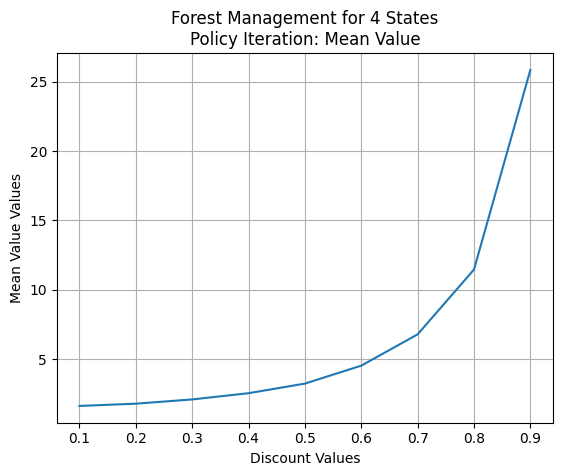

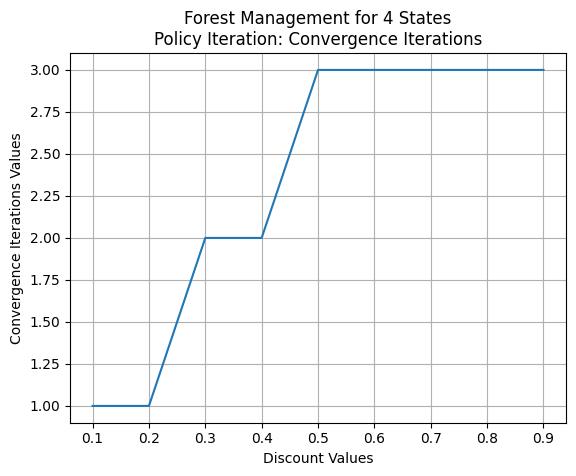

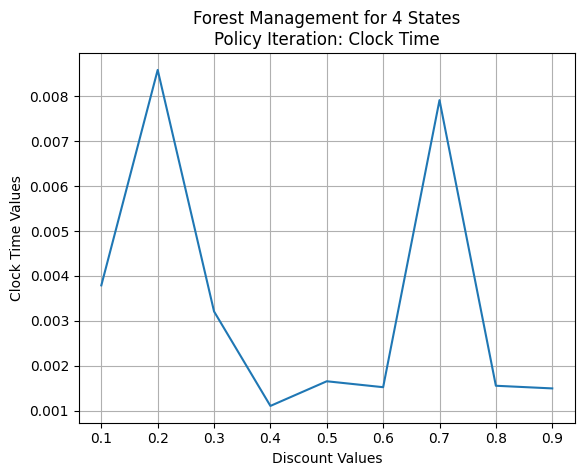

0.1    (0, 1, 1, 0)
0.2    (0, 1, 1, 0)
0.3    (0, 1, 0, 0)
0.4    (0, 1, 0, 0)
0.5    (0, 0, 0, 0)
0.6    (0, 0, 0, 0)
0.7    (0, 0, 0, 0)
0.8    (0, 0, 0, 0)
0.9    (0, 0, 0, 0)
Name: policy, dtype: object


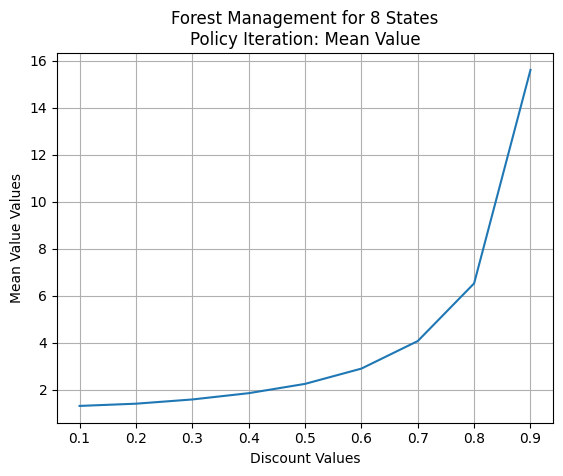

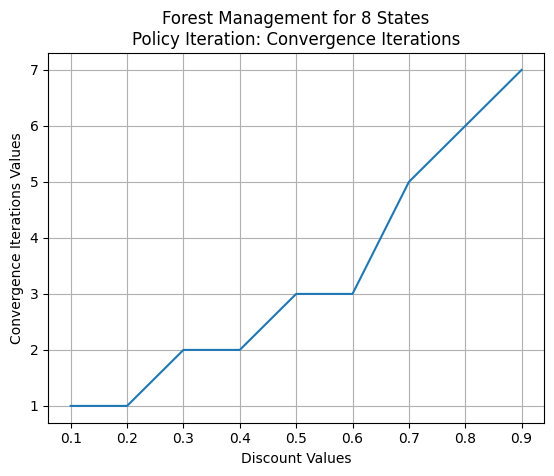

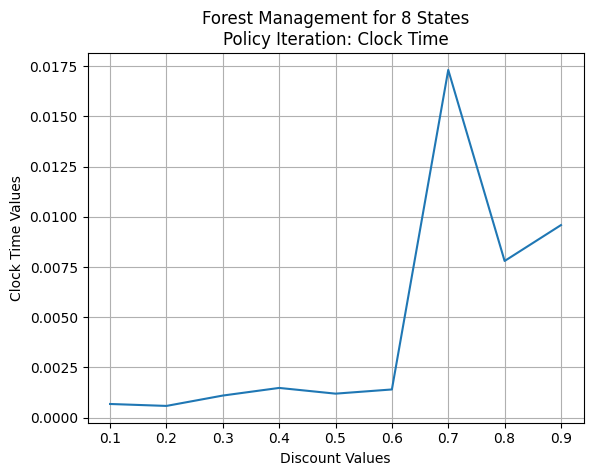

0.1    (0, 1, 1, 1, 1, 1, 1, 0)
0.2    (0, 1, 1, 1, 1, 1, 1, 0)
0.3    (0, 1, 1, 1, 1, 1, 0, 0)
0.4    (0, 1, 1, 1, 1, 1, 0, 0)
0.5    (0, 1, 1, 1, 1, 0, 0, 0)
0.6    (0, 1, 1, 1, 1, 0, 0, 0)
0.7    (0, 1, 1, 0, 0, 0, 0, 0)
0.8    (0, 1, 0, 0, 0, 0, 0, 0)
0.9    (0, 0, 0, 0, 0, 0, 0, 0)
Name: policy, dtype: object


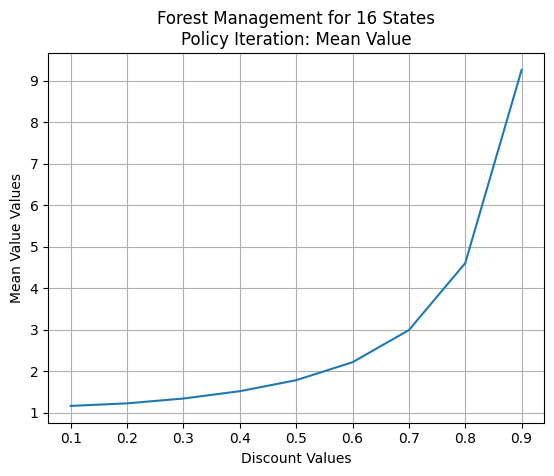

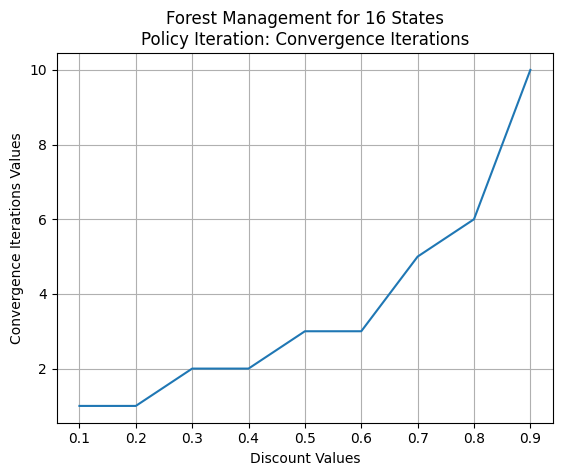

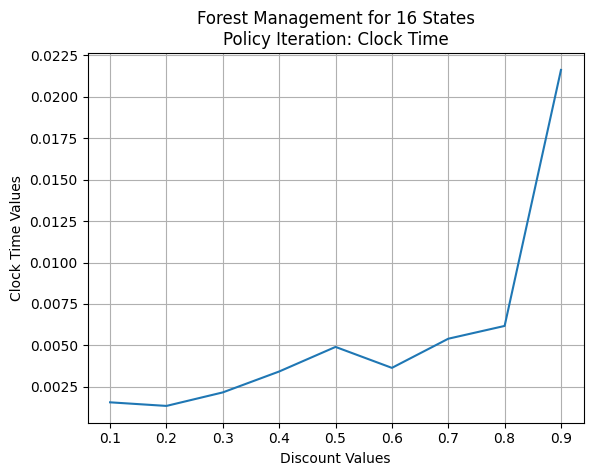

0.1    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
0.2    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
0.3    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0)
0.4    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0)
0.5    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
0.6    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
0.7    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0)
0.8    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
0.9    (0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Name: policy, dtype: object


In [ ]:
for size in pi_forest_dict.keys():
    results_df = pi_forest_dict[size]
    for col in ['Mean Value','Convergence Iterations','Clock Time']:
        plt.plot(results_df.index,results_df[col])
        plt.xlabel('Discount Values')
        plt.ylabel(col+' Values')
        plt.title('Forest Management for '+ str(size) + ' States\nPolicy Iteration: '+ col)
        plt.grid()
        plt.show()
    print(results_df['policy'])

In [ ]:
vi_forest_dict = VI_Forest_grid_search(gamma_list=gamma_list,forest_dict=forest_dict,max_iter=200)
vi_forest_dict

4
running -- with gamma:  0.1
  Iteration		V-variation
    1		  4.0
    2		  0.3600000000000003
Iterating stopped due to maximum number of iterations condition.
running -- with gamma:  0.2
  Iteration		V-variation
    1		  4.0
    2		  0.7199999999999998
    3		  0.12960000000000044
Iterating stopped due to maximum number of iterations condition.
running -- with gamma:  0.3
  Iteration		V-variation
    1		  4.0
    2		  1.08
    3		  0.29159999999999986
    4		  0.07873200000000002
Iterating stopped due to maximum number of iterations condition.
running -- with gamma:  0.4
  Iteration		V-variation
    1		  4.0
    2		  1.4400000000000004
    3		  0.5184000000000002
    4		  0.18662400000000012
    5		  0.06718464000000024
    6		  0.024186470400000326
Iterating stopped due to maximum number of iterations condition.
running -- with gamma:  0.5
  Iteration		V-variation
    1		  4.0
    2		  1.7999999999999998
    3		  0.8100000000000005
    4		  0.3645000000000005
    5		  0.164024999999

{4:     Mean Value        policy Convergence Iterations Clock Time
 0.1     1.6125  (0, 1, 1, 0)                      2   0.001461
 0.2     1.7772  (0, 1, 1, 0)                      3   0.002878
 0.3   2.076342  (0, 1, 0, 0)                      4   0.001011
 0.4   2.533971  (0, 1, 0, 0)                      6   0.000357
 0.5   3.197679  (0, 0, 0, 0)                      7   0.000464
 0.6   4.210414  (0, 0, 0, 0)                      6   0.003133
 0.7   5.203499  (0, 0, 0, 0)                      5   0.003098
 0.8    6.76553  (0, 0, 0, 0)                      5   0.002501
 0.9   8.751911  (0, 0, 0, 0)                      5   0.002542,
 8:     Mean Value                    policy Convergence Iterations Clock Time
 0.1    1.30625  (0, 1, 1, 1, 1, 1, 1, 0)                      2   0.001076
 0.2     1.4066  (0, 1, 1, 1, 1, 1, 1, 0)                      3   0.002876
 0.3   1.579886  (0, 1, 1, 1, 1, 1, 0, 0)                      4   0.002106
 0.4   1.853183  (0, 1, 1, 1, 1, 1, 0, 0)        

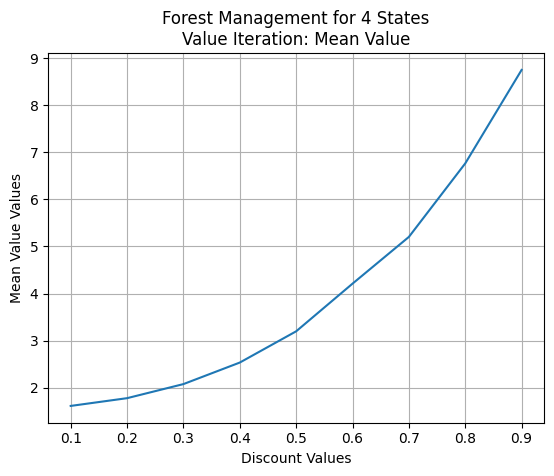

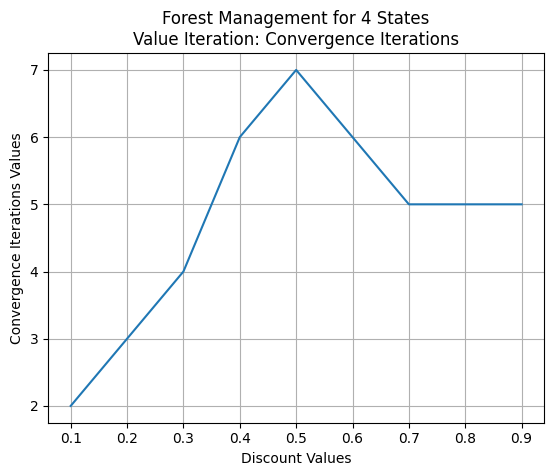

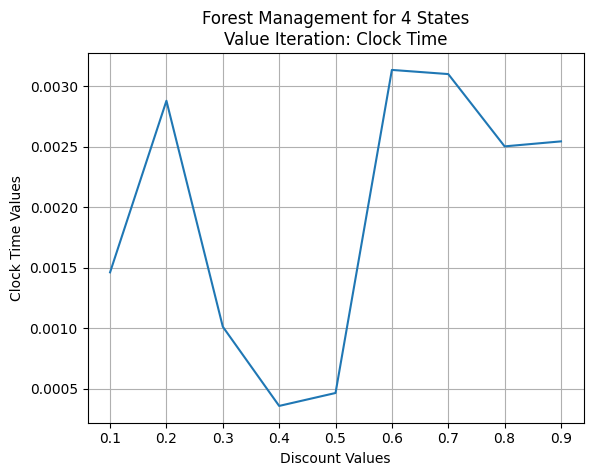

0.1    (0, 1, 1, 0)
0.2    (0, 1, 1, 0)
0.3    (0, 1, 0, 0)
0.4    (0, 1, 0, 0)
0.5    (0, 0, 0, 0)
0.6    (0, 0, 0, 0)
0.7    (0, 0, 0, 0)
0.8    (0, 0, 0, 0)
0.9    (0, 0, 0, 0)
Name: policy, dtype: object


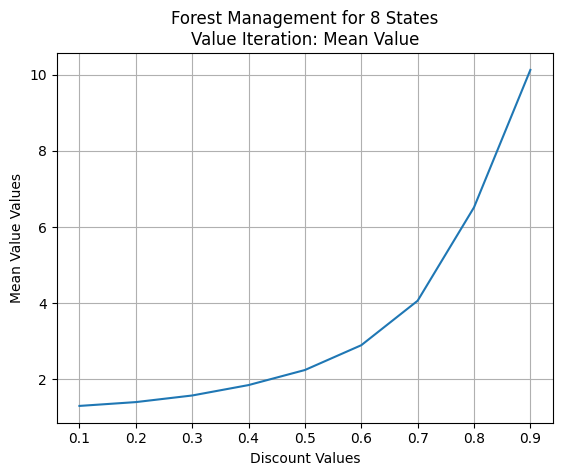

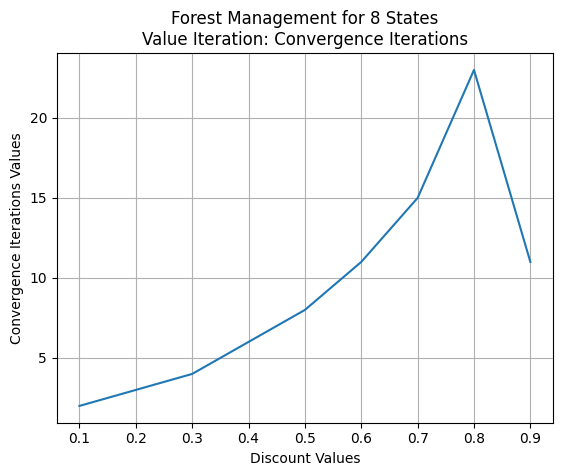

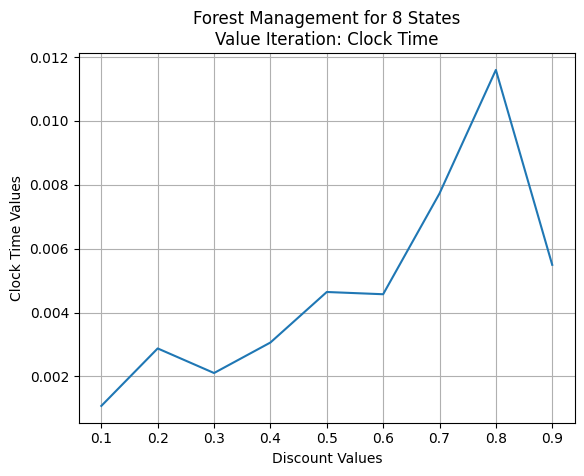

0.1    (0, 1, 1, 1, 1, 1, 1, 0)
0.2    (0, 1, 1, 1, 1, 1, 1, 0)
0.3    (0, 1, 1, 1, 1, 1, 0, 0)
0.4    (0, 1, 1, 1, 1, 1, 0, 0)
0.5    (0, 1, 1, 1, 1, 0, 0, 0)
0.6    (0, 1, 1, 1, 1, 0, 0, 0)
0.7    (0, 1, 1, 0, 0, 0, 0, 0)
0.8    (0, 1, 0, 0, 0, 0, 0, 0)
0.9    (0, 0, 0, 0, 0, 0, 0, 0)
Name: policy, dtype: object


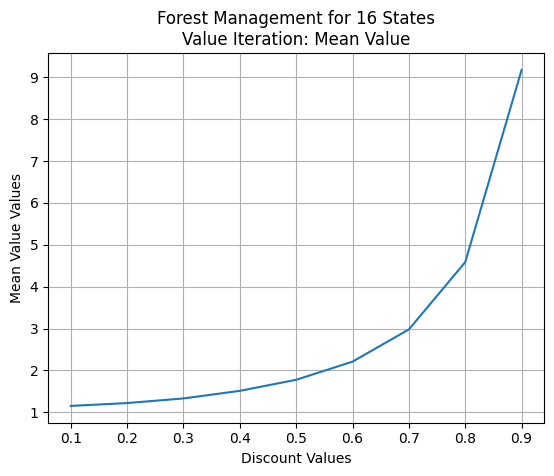

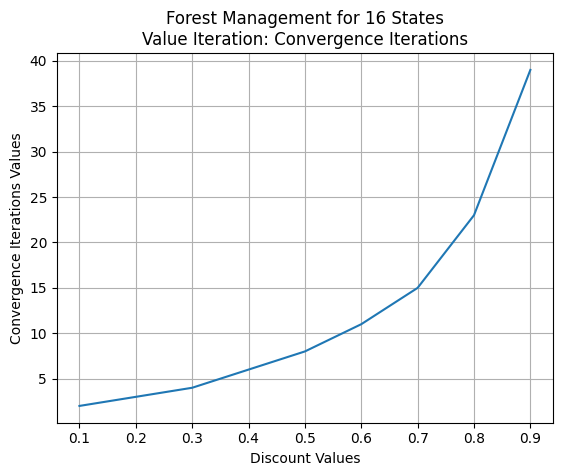

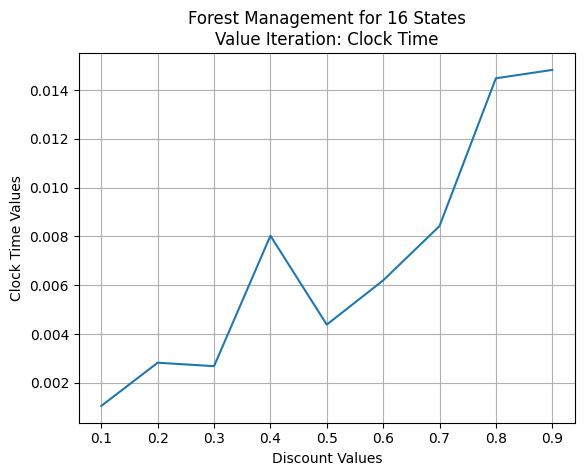

0.1    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
0.2    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
0.3    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0)
0.4    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0)
0.5    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
0.6    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
0.7    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0)
0.8    (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
0.9    (0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Name: policy, dtype: object


In [ ]:
for size in vi_forest_dict.keys():
    results_df = vi_forest_dict[size]
    for col in ['Mean Value','Convergence Iterations','Clock Time']:
        plt.plot(results_df.index,results_df[col])
        plt.xlabel('Discount Values')
        plt.ylabel(col+' Values')
        plt.title('Forest Management for '+ str(size) + ' States\nValue Iteration: '+ col)
        plt.grid()
        plt.show()
    print(results_df['policy'])

In [ ]:
ql_forest_dict = QL_Forest_grid_search(gamma_list=gamma_list,forest_dict=forest_dict,n_iter=100000)
ql_forest_dict

4
running -- with gamma:  0.1
running -- with gamma:  0.2
running -- with gamma:  0.3
running -- with gamma:  0.4
running -- with gamma:  0.5
running -- with gamma:  0.6
running -- with gamma:  0.7
running -- with gamma:  0.8
running -- with gamma:  0.9
8
running -- with gamma:  0.1
running -- with gamma:  0.2
running -- with gamma:  0.3
running -- with gamma:  0.4
running -- with gamma:  0.5
running -- with gamma:  0.6
running -- with gamma:  0.7
running -- with gamma:  0.8
running -- with gamma:  0.9
16
running -- with gamma:  0.1
running -- with gamma:  0.2
running -- with gamma:  0.3
running -- with gamma:  0.4
running -- with gamma:  0.5
running -- with gamma:  0.6
running -- with gamma:  0.7
running -- with gamma:  0.8
running -- with gamma:  0.9


{4:                                               Q Matrix Mean Value  \
 0.1  [[0.09313883104074426, 0.009199958142200801], ...   1.628156   
 0.2  [[0.19146083672993133, 0.03813232032732011], [...   1.746868   
 0.3  [[0.3065850793941115, 0.09116476669110829], [0...   2.086753   
 0.4  [[0.4441744052973742, 0.17687514238583166], [0...    2.53254   
 0.5  [[0.714823271449887, 0.33172564953317935], [1....   3.220405   
 0.6  [[1.5836096153547503, 0.7269191486335148], [2....   4.516109   
 0.7  [[3.37152923910468, 2.308353971130268], [4.924...   6.859506   
 0.8  [[7.469785991658588, 5.28291142409669], [9.524...  11.506638   
 0.9  [[21.447504996059138, 18.914722597278217], [24...  26.089289   
 
            policy Average Mean Value Discrepancy Clock Time  
 0.1  (0, 1, 1, 0)                        0.00016   1.720376  
 0.2  (0, 1, 0, 0)                       0.000329   2.667091  
 0.3  (0, 1, 0, 0)                       0.000499   2.573044  
 0.4  (0, 1, 0, 0)                       0.

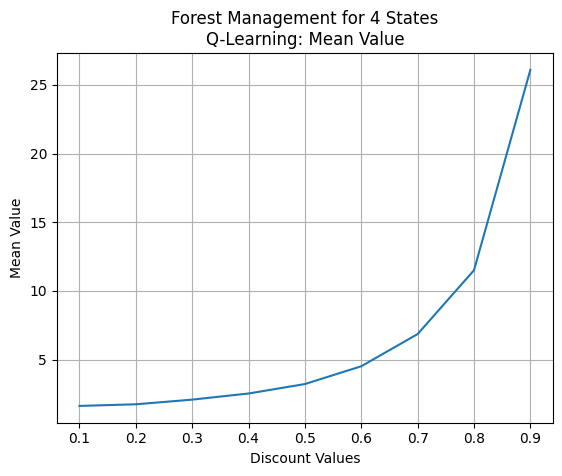

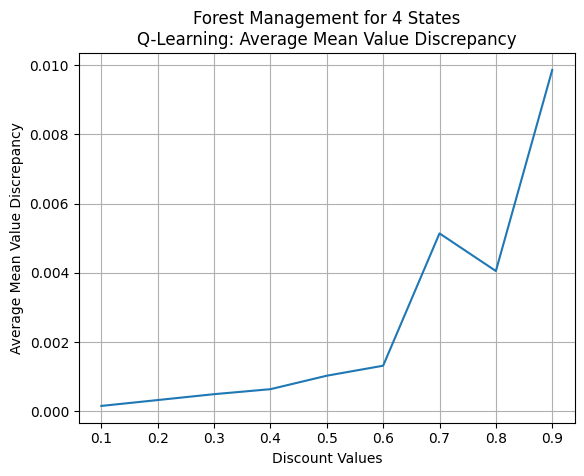

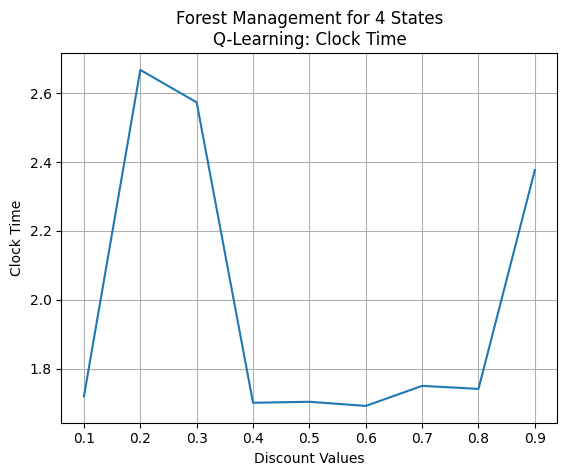

0.1    (0, 1, 1, 0)
0.2    (0, 1, 0, 0)
0.3    (0, 1, 0, 0)
0.4    (0, 1, 0, 0)
0.5    (0, 0, 0, 0)
0.6    (0, 0, 0, 0)
0.7    (0, 0, 0, 0)
0.8    (0, 0, 0, 0)
0.9    (0, 0, 0, 0)
Name: policy, dtype: object


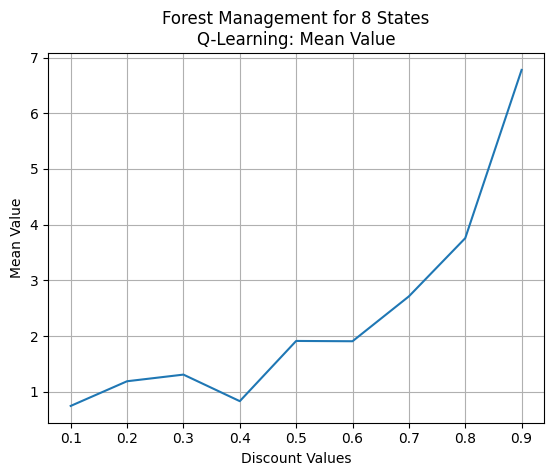

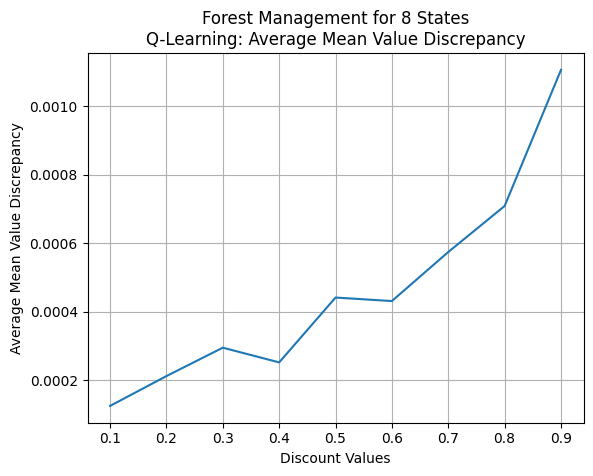

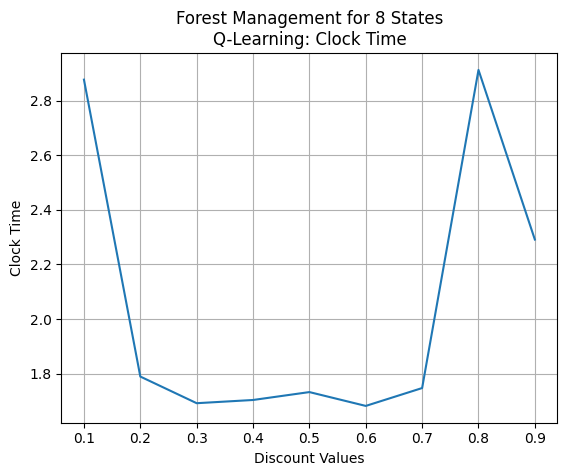

0.1    (0, 1, 1, 1, 1, 1, 1, 1)
0.2    (0, 1, 1, 1, 1, 0, 1, 0)
0.3    (0, 1, 1, 1, 1, 0, 0, 0)
0.4    (0, 1, 1, 1, 1, 0, 1, 1)
0.5    (0, 1, 1, 1, 1, 0, 0, 0)
0.6    (0, 1, 1, 0, 1, 0, 1, 0)
0.7    (0, 1, 1, 1, 1, 1, 0, 0)
0.8    (0, 1, 1, 0, 1, 1, 0, 0)
0.9    (0, 1, 1, 1, 1, 0, 0, 0)
Name: policy, dtype: object


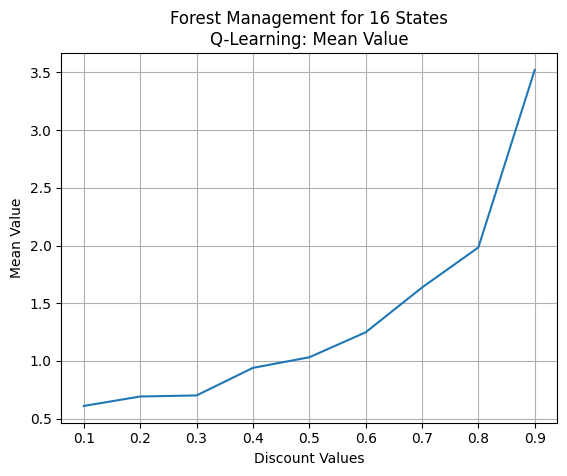

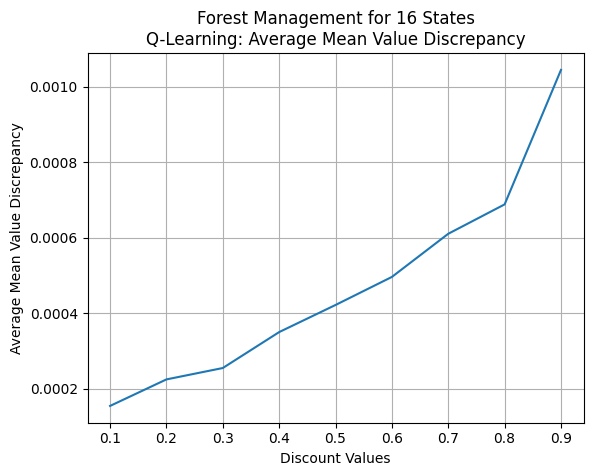

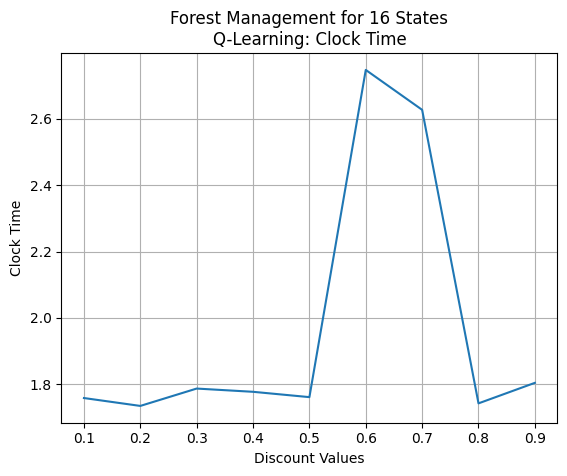

0.1    (0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0)
0.2    (0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
0.3    (0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0)
0.4    (0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0)
0.5    (0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0)
0.6    (0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0)
0.7    (0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0)
0.8    (0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0)
0.9    (0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0)
Name: policy, dtype: object


In [ ]:
for size in ql_forest_dict.keys():
    results_df = ql_forest_dict[size]
    for col in ['Mean Value','Average Mean Value Discrepancy', 'Clock Time']:
        plt.plot(results_df.index,results_df[col])
        plt.xlabel('Discount Values')
        plt.ylabel(col)
        plt.title('Forest Management for '+ str(size) + ' States\nQ-Learning: '+ col)
        plt.grid()
        plt.show()
    print(results_df['policy'])

## Gridworld Problem: Frozen Lake

In [ ]:
def PI_FLake_grid_search(gamma_list,flake_dict,n_iters,conv_crit):
    pi_flake_dict = {}
    for size in flake_dict.keys():
        print(size)
        frozen_lake = flake_dict[size]
        frozen_lake.reset(seed=42)
        results_df = pd.DataFrame(index=gamma_list,columns=['V','Mean Value','policy','Convergence Iterations','Clock Time'])
        for i in range(len(gamma_list)):
            print("running -- with gamma: ", str(gamma_list[i]))
            start_time = time.time()
            V, V_track, pi = Planner(frozen_lake.P).policy_iteration(n_iters=n_iters, gamma=gamma_list[i])
            end_time = time.time()
            run_time = end_time - start_time
            dist_list = [math.dist(V,x) for x in V_track]
            conv_index = next(x for x, val in enumerate(dist_list) if val < conv_crit)
            # policy space calculation
            j=0
            action_space = pd.DataFrame([[0] * size] * size)
            for c in range(size):
                for r in range(size):
                    action_space[r][c] = pi(s=j)
                    j+=1

            results_df.iloc[i] = [V.reshape((size, size)),np.mean(V), action_space, conv_index, run_time]

        pi_flake_dict[size] = results_df
    return pi_flake_dict

def VI_FLake_grid_search(gamma_list,flake_dict,n_iters,conv_crit):
    vi_flake_dict = {}
    for size in flake_dict.keys():
        print(size)
        frozen_lake = flake_dict[size]
        frozen_lake.reset(seed=42)
        results_df = pd.DataFrame(index=gamma_list,columns=['V','Mean Value','policy','Convergence Iterations','Clock Time'])
        for i in range(len(gamma_list)):
            print("running -- with gamma: ", str(gamma_list[i]))
            start_time = time.time()
            V, V_track, pi = Planner(frozen_lake.P).value_iteration(n_iters=n_iters, gamma=gamma_list[i])
            end_time = time.time()
            run_time = end_time - start_time
            dist_list = [math.dist(V,x) for x in V_track]
            conv_index = next(x for x, val in enumerate(dist_list) if val < conv_crit)
            # policy space calculation
            j=0
            action_space = pd.DataFrame([[0] * size] * size)
            for c in range(size):
                for r in range(size):
                    action_space[r][c] = pi(s=j)
                    j+=1
            results_df.iloc[i] = [V.reshape((size, size)),np.mean(V), action_space, conv_index, run_time]

        vi_flake_dict[size] = results_df
    return vi_flake_dict

def QL_FLake_grid_search(gamma_list,flake_dict,iter_multiple):
    ql_flake_dict = {}
    for size in flake_dict.keys():
        print(size)
        n_iters = iter_multiple * size
        frozen_lake = flake_dict[size]
        frozen_lake.reset(seed=42)
        results_df = pd.DataFrame(index=gamma_list,columns=['V','Q Matrix','Mean Value','policy','Average Mean Value Discrepancy', 'Clock Time'])
        for i in range(len(gamma_list)):
            print("running -- with gamma: ", str(gamma_list[i]))
            start_time = time.time()
            Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(nS=frozen_lake.observation_space.n, nA=frozen_lake.action_space.n,
                                                                          init_epsilon=1,epsilon_decay_ratio=0.99,
                                                                          init_alpha = 0.1, alpha_decay_ratio=1,
                                                                          n_episodes=n_iters,gamma=gamma_list[i])
            end_time = time.time()
            def chunks(lst, n):
                """Yield successive n-sized chunks from lst."""
                for i in range(0, len(lst), n):
                    yield lst[i:i + n]

            V_discrepancy = []
            for Q in Q_track:
                V_i = [row.max() for row in Q]
                V_discrepancy.append(math.dist(V,V_i))
            mean_discrepancy = []
            for chunk in chunks(V_discrepancy, 100):
                  mean_discrepancy.append(np.mean(chunk))

            run_time = end_time - start_time

            # policy space calculation
            j=0
            action_space = pd.DataFrame([[0] * size] * size)
            for c in range(size):
                for r in range(size):
                    action_space[r][c] = pi(s=j)
                    j+=1

            results_df.iloc[i] = [V.reshape((size, size)),Q,np.mean(V),action_space,np.mean(mean_discrepancy),run_time]

        ql_flake_dict[size] = results_df
    return ql_flake_dict

In [ ]:
size_list = [4,8,16]
flake_dict = {}
for size in size_list:
    #frozen_lake = gym.make('FrozenLake-v1', is_slippery=True, desc=generate_random_map(size=size, p =0.95))
    frozen_lake = FrozenLakeEnv(desc=generate_random_map(size=size, p =0.8))
    frozen_lake.reset(seed=42)
    flake_dict[size] = frozen_lake

In [ ]:
gamma_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
pi_flake_dict = PI_FLake_grid_search(gamma_list=gamma_list,flake_dict=flake_dict,n_iters=10000,conv_crit=1e-10)
pi_flake_dict

4
running -- with gamma:  0.1
runtime = 0.05 seconds
running -- with gamma:  0.2
runtime = 0.06 seconds
running -- with gamma:  0.3
runtime = 0.10 seconds
running -- with gamma:  0.5
runtime = 0.22 seconds
running -- with gamma:  0.6
runtime = 0.16 seconds
running -- with gamma:  0.7
runtime = 0.22 seconds
running -- with gamma:  0.8
runtime = 0.36 seconds
running -- with gamma:  0.9
runtime = 0.89 seconds
running -- with gamma:  0.95
runtime = 0.39 seconds
running -- with gamma:  0.99
runtime = 0.92 seconds
8
running -- with gamma:  0.1
runtime = 0.14 seconds
running -- with gamma:  0.2
runtime = 0.41 seconds
running -- with gamma:  0.3
runtime = 0.56 seconds
running -- with gamma:  0.4
runtime = 0.53 seconds
running -- with gamma:  0.5
runtime = 0.37 seconds
running -- with gamma:  0.6
runtime = 0.53 seconds
running -- with gamma:  0.7
runtime = 0.62 seconds
running -- with gamma:  0.8
runtime = 1.21 seconds
running -- with gamma:  0.9
runtime = 4.20 seconds
running -- with gamma:  0

{4:                                                       V Mean Value  \
 0.10  [[-0.055555052213111605, 0.0, 0.0, -0.05555314...   0.075373   
 0.20  [[-0.06247995160435847, 0.0, 0.0, -0.062453899...   0.085083   
 0.30  [[-0.0712330196684565, 0.0, 0.0, -0.0711395464...   0.097855   
 0.40  [[-0.08223481871973004, 0.0, 0.0, -0.082152278...   0.115427   
 0.50  [[-0.0953235860802639, 0.0, 0.0, -0.0960601040...   0.141012   
 0.60  [[-0.10779868121431108, 0.0, 0.0, -0.112966210...    0.18112   
 0.70  [[-0.1071885722172342, 0.0, 0.0, -0.1300142983...   0.250761   
 0.80  [[-0.04088978922188042, 0.0, 0.0, -0.127129058...   0.391769   
 0.90  [[0.3534740000037928, 0.0, 0.0, 0.049323664810...   0.767537   
 0.95  [[1.1055278604356844, 0.0, 0.0, 0.566259216461...   1.299079   
 0.99  [[2.853648458241348, 0.0, 0.0, 2.2627566732487...   2.409317   
 
                                                  policy  \
 0.10     0  1  2  3
 0  0  0  0  2
 1  1  1  1  3
 2  1...   
 0.20     0  1  2  3

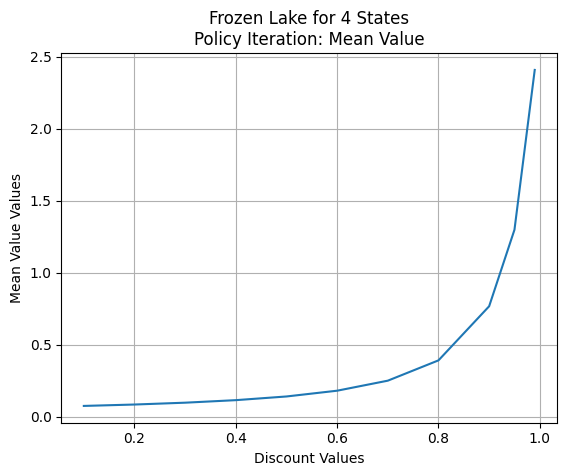

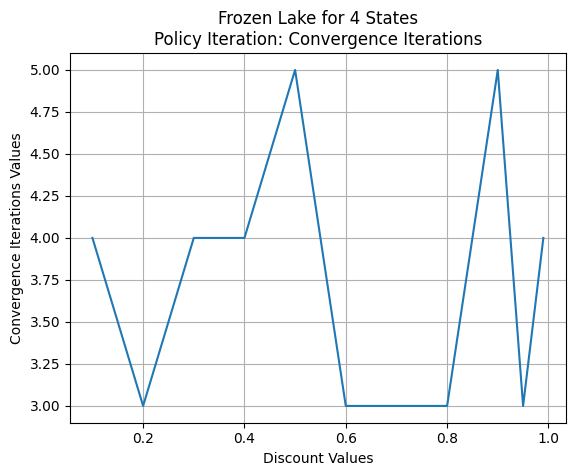

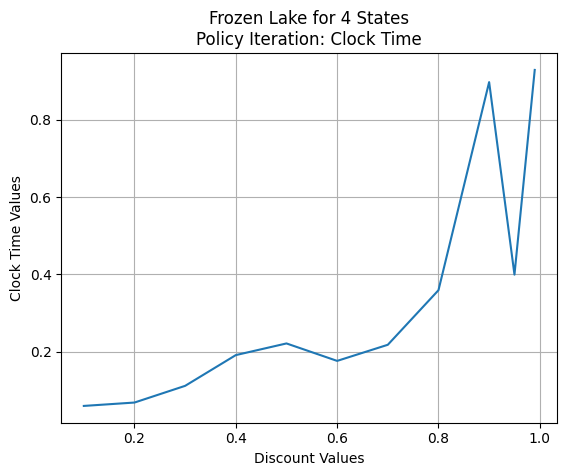

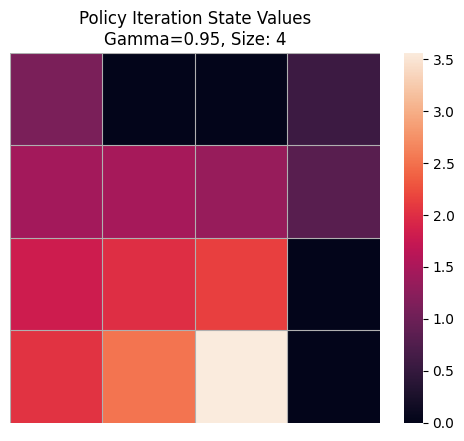

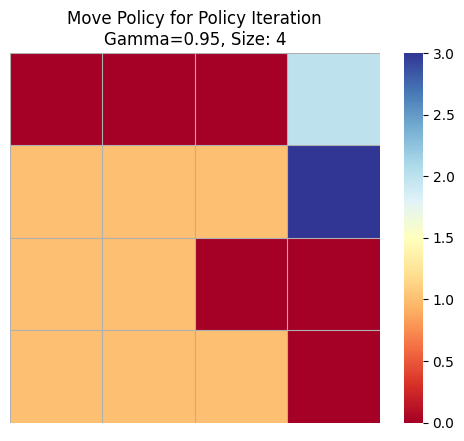

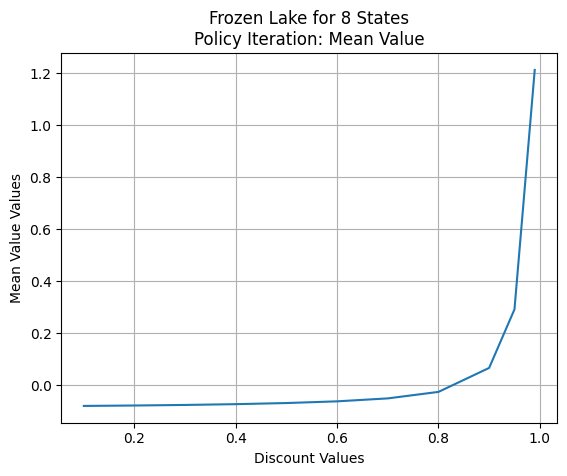

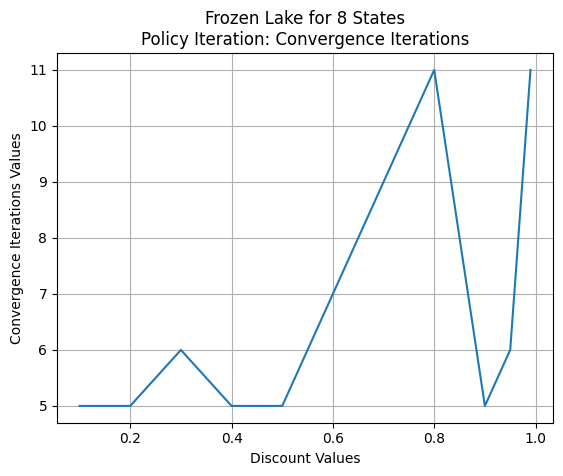

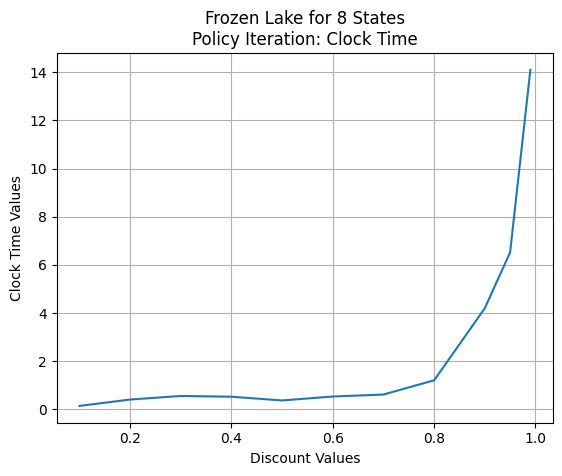

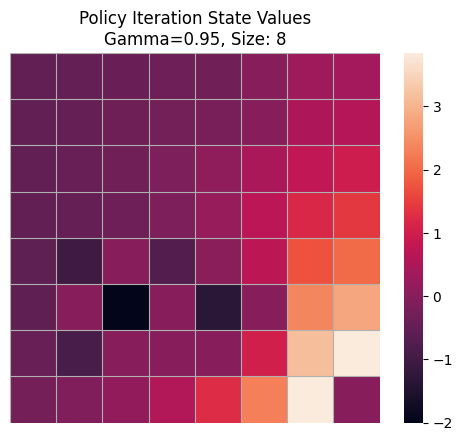

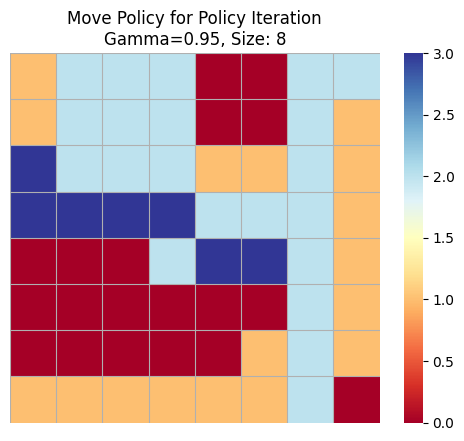

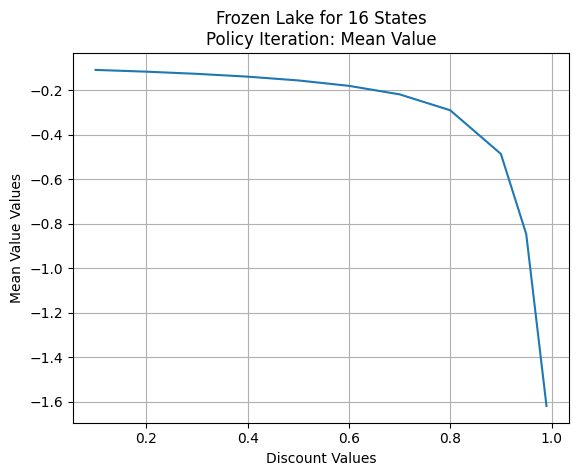

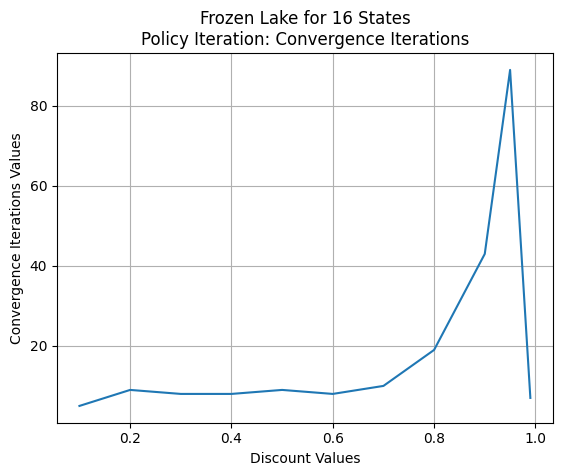

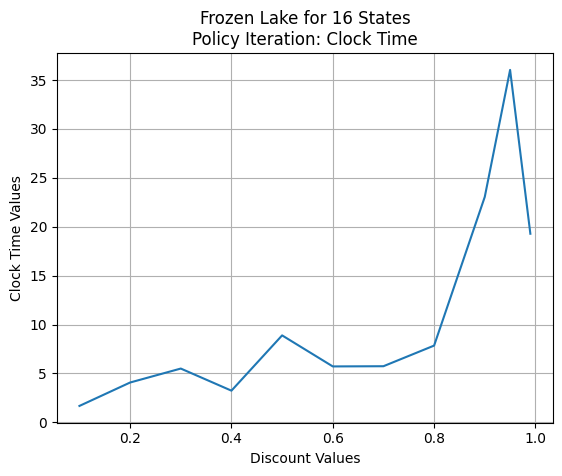

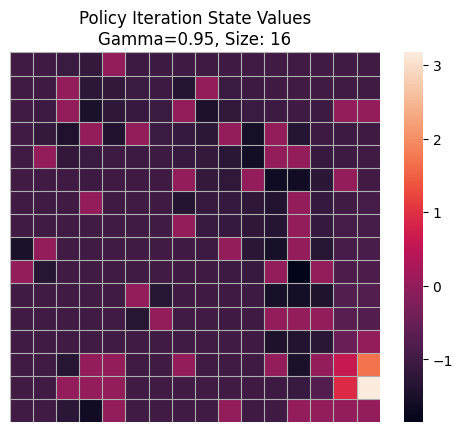

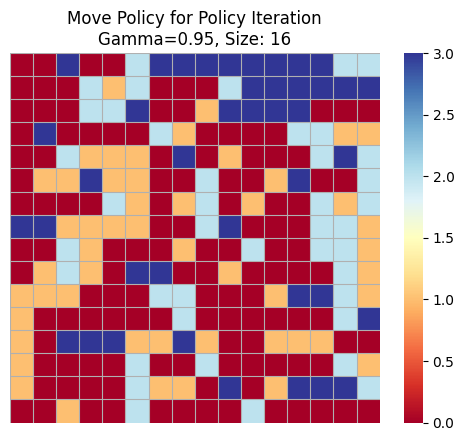

In [ ]:
for size in pi_flake_dict.keys():
    results_df = pi_flake_dict[size]
    for col in ['Mean Value','Convergence Iterations','Clock Time']:
        plt.plot(results_df.index,results_df[col])
        plt.xlabel('Discount Values')
        plt.ylabel(col+' Values')
        plt.title('Frozen Lake for '+ str(size) + ' States\nPolicy Iteration: '+ col)
        plt.grid()
        plt.show()

    # Values Visualization for gamma 0.99
    fig, ax = plt.subplots()
    sns.heatmap(pi_flake_dict[size]['V'][0.95], square=True)
    ax.set_xticks(np.arange(0,size,1))
    ax.set_yticks(np.arange(0,size,1))
    plt.grid(which='major')
    plt.tick_params(axis='both',which='both',left=False,right=False,bottom=False,top=False,labelbottom=False,labelleft=False)
    plt.title("Policy Iteration State Values\nGamma=0.95, Size: "+str(size))
    plt.show()

    # Policy Visualization for gamma 0.99
    fig, ax = plt.subplots()
    sns.heatmap(pi_flake_dict[size]['policy'][0.95], square=True, cmap ="RdYlBu")
    plt.title("Move Policy for Policy Iteration\nGamma=0.95, Size: "+str(size))
    ax.set_xticks(np.arange(0,size,1))
    ax.set_yticks(np.arange(0,size,1))
    plt.tick_params(axis='both',which='both',left=False,right=False,bottom=False,top=False,labelbottom=False,labelleft=False)
    plt.grid(which='major')
    plt.show()

In [ ]:
vi_flake_dict = VI_FLake_grid_search(gamma_list=gamma_list,flake_dict=flake_dict,n_iters=1000,conv_crit=1e-10)
vi_flake_dict

4
running -- with gamma:  0.1
runtime = 0.01 seconds
running -- with gamma:  0.2
runtime = 0.00 seconds
running -- with gamma:  0.3
runtime = 0.00 seconds
running -- with gamma:  0.4
runtime = 0.01 seconds
running -- with gamma:  0.5
runtime = 0.01 seconds
running -- with gamma:  0.6
runtime = 0.01 seconds
running -- with gamma:  0.7
runtime = 0.01 seconds
running -- with gamma:  0.8
runtime = 0.01 seconds
running -- with gamma:  0.9
runtime = 0.03 seconds
running -- with gamma:  0.95
runtime = 0.04 seconds
running -- with gamma:  0.99
runtime = 0.06 seconds
8
running -- with gamma:  0.1
runtime = 0.01 seconds
running -- with gamma:  0.2
runtime = 0.02 seconds
running -- with gamma:  0.3
runtime = 0.02 seconds
running -- with gamma:  0.4
runtime = 0.02 seconds
running -- with gamma:  0.5
runtime = 0.02 seconds
running -- with gamma:  0.6
runtime = 0.03 seconds
running -- with gamma:  0.7
runtime = 0.04 seconds
running -- with gamma:  0.8
runtime = 0.07 seconds
running -- with gamma:  0

{4:                                                       V Mean Value  \
 0.10  [[-0.055555052214221155, 0.0, 0.0, -0.05555314...   0.075373   
 0.20  [[-0.06247995159987513, 0.0, 0.0, -0.062453899...   0.085083   
 0.30  [[-0.07123301967176791, 0.0, 0.0, -0.071139546...   0.097855   
 0.40  [[-0.08223481872229688, 0.0, 0.0, -0.082152278...   0.115427   
 0.50  [[-0.09532358607202443, 0.0, 0.0, -0.096060104...   0.141012   
 0.60  [[-0.10779868117783839, 0.0, 0.0, -0.112966210...    0.18112   
 0.70  [[-0.1071885722432045, 0.0, 0.0, -0.1300142983...   0.250761   
 0.80  [[-0.040889789239747676, 0.0, 0.0, -0.12712905...   0.391769   
 0.90  [[0.3534740000041774, 0.0, 0.0, 0.049323664797...   0.767537   
 0.95  [[1.1055278603836478, 0.0, 0.0, 0.566259216489...   1.299079   
 0.99  [[2.853648458254789, 0.0, 0.0, 2.2627566732623...   2.409317   
 
                                                  policy  \
 0.10     0  1  2  3
 0  0  0  0  2
 1  1  1  1  3
 2  1...   
 0.20     0  1  2  3

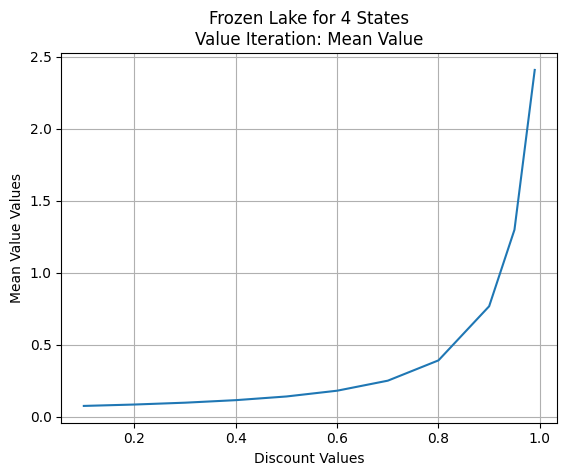

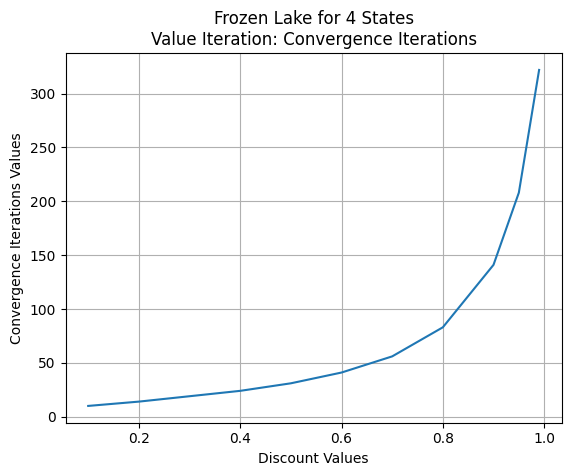

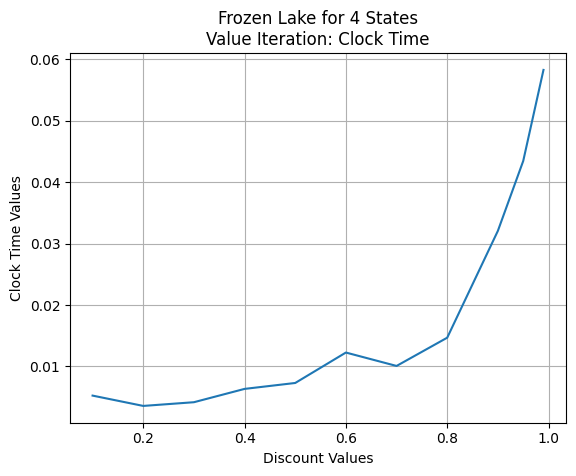

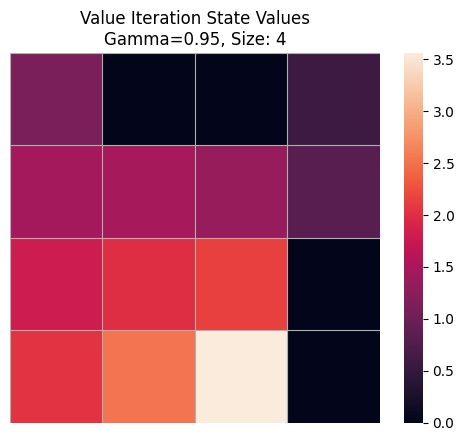

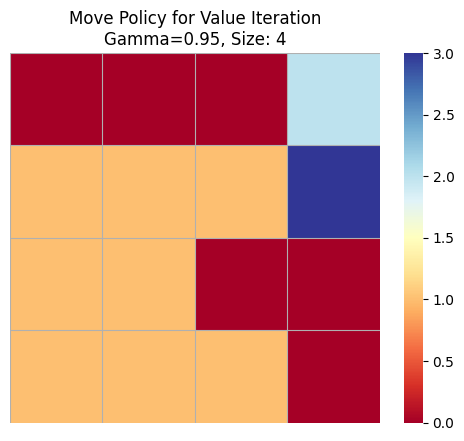

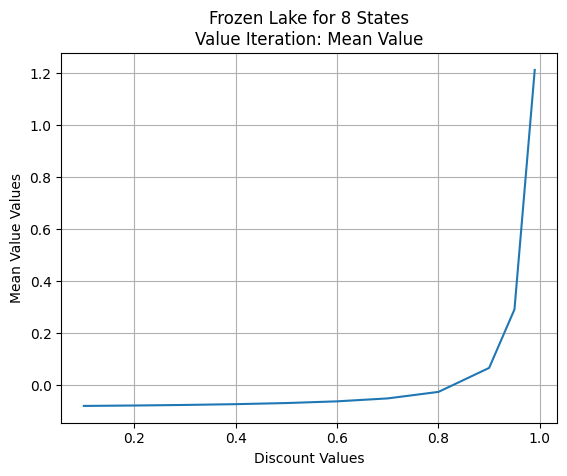

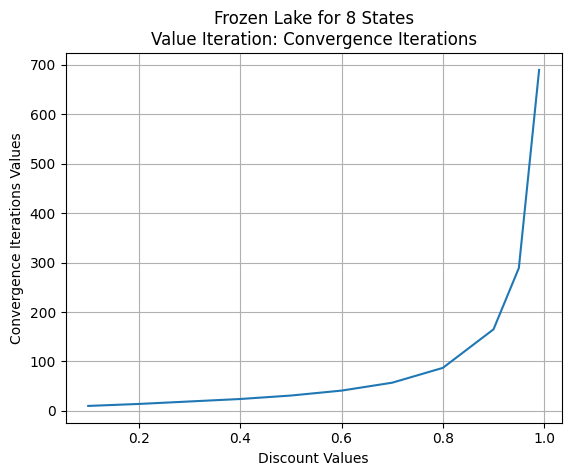

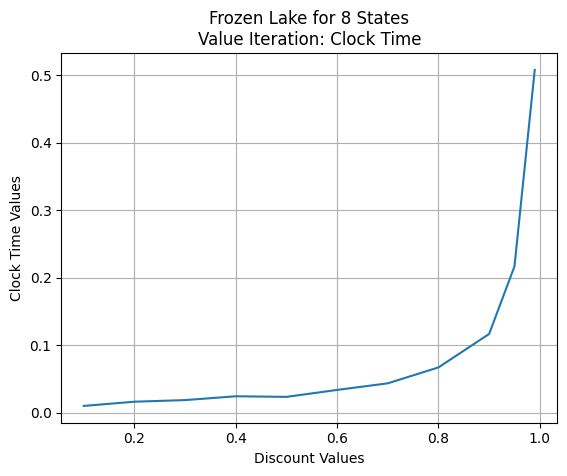

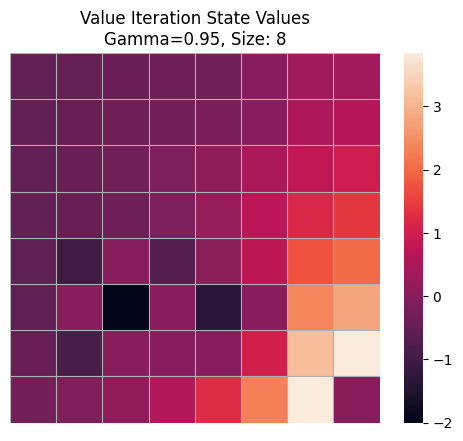

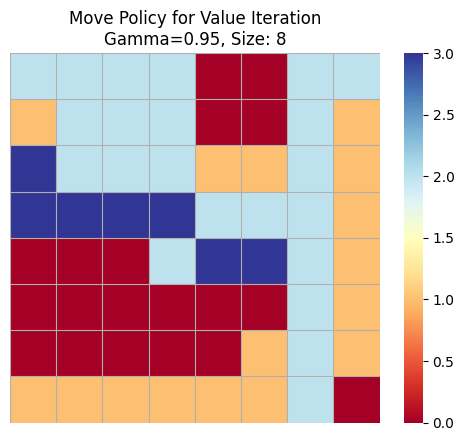

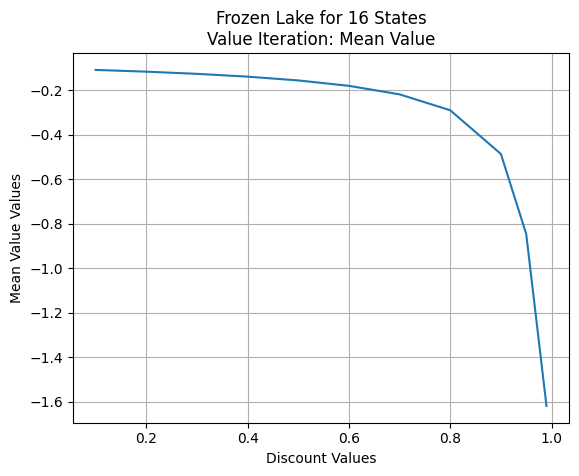

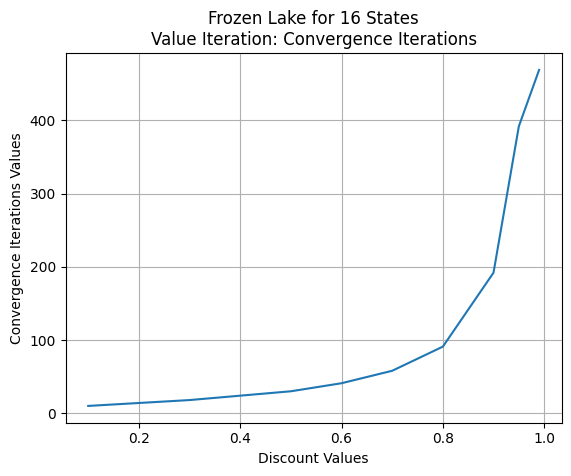

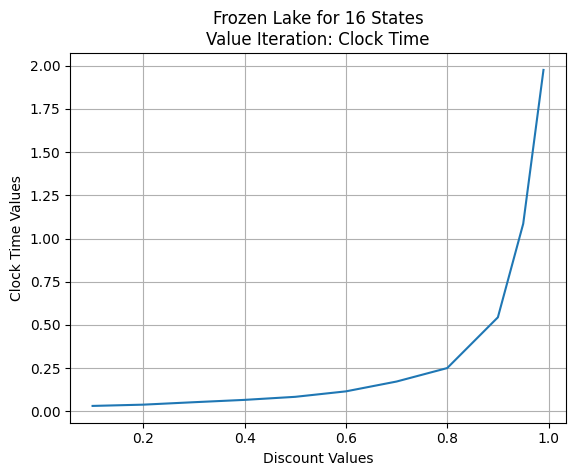

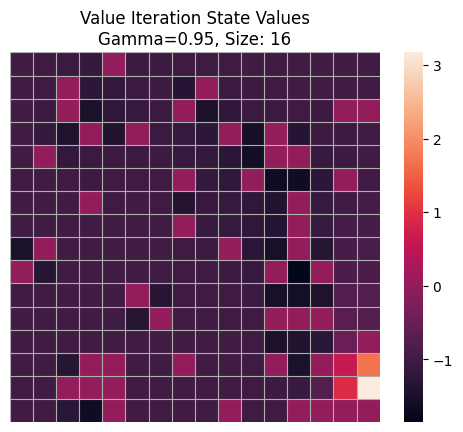

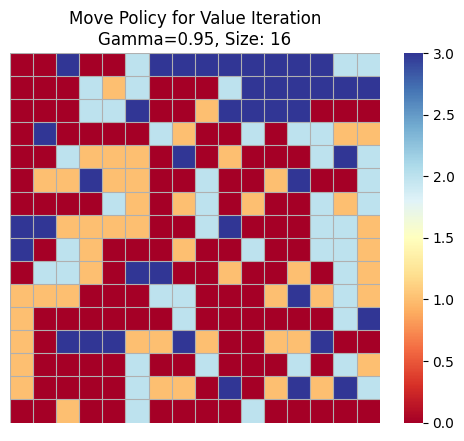

In [ ]:
for size in vi_flake_dict.keys():
    results_df = vi_flake_dict[size]
    for col in ['Mean Value','Convergence Iterations','Clock Time']:
        plt.plot(results_df.index,results_df[col])
        plt.xlabel('Discount Values')
        plt.ylabel(col+' Values')
        plt.title('Frozen Lake for '+ str(size) + ' States\nValue Iteration: '+ col)
        plt.grid()
        plt.show()
    # Values Visualization for gamma 0.99
    fig, ax = plt.subplots()
    sns.heatmap(vi_flake_dict[size]['V'][0.95], square=True)
    ax.set_xticks(np.arange(0,size,1))
    ax.set_yticks(np.arange(0,size,1))
    plt.grid(which='major')
    plt.tick_params(axis='both',which='both',left=False,right=False,bottom=False,top=False,labelbottom=False,labelleft=False)
    plt.title("Value Iteration State Values\nGamma=0.95, Size: "+str(size))
    plt.show()

    # Policy Visualization for gamma 0.99
    fig, ax = plt.subplots()
    sns.heatmap(vi_flake_dict[size]['policy'][0.95], square=True, cmap ="RdYlBu")
    plt.title("Move Policy for Value Iteration\nGamma=0.95, Size: "+str(size))
    ax.set_xticks(np.arange(0,size,1))
    ax.set_yticks(np.arange(0,size,1))
    plt.tick_params(axis='both',which='both',left=False,right=False,bottom=False,top=False,labelbottom=False,labelleft=False)
    plt.grid(which='major')
    plt.show()

In [ ]:
gc.collect()

35

In [ ]:
gamma_list = [0.1,0.3,0.5,0.7,0.9,0.95]
ql_flake_dict = QL_FLake_grid_search(gamma_list=gamma_list,flake_dict=flake_dict,iter_multiple=int(8000)) # 100000
ql_flake_dict

4
running -- with gamma:  0.1


runtime = 20.36 seconds
running -- with gamma:  0.3


runtime = 21.58 seconds
running -- with gamma:  0.5


runtime = 19.64 seconds
running -- with gamma:  0.7


runtime = 20.38 seconds
running -- with gamma:  0.9


runtime = 18.90 seconds
running -- with gamma:  0.95


runtime = 18.85 seconds
8
running -- with gamma:  0.1


runtime = 119.21 seconds
running -- with gamma:  0.3


runtime = 107.05 seconds
running -- with gamma:  0.5


runtime = 104.54 seconds
running -- with gamma:  0.7


runtime = 94.98 seconds
running -- with gamma:  0.9


runtime = 92.24 seconds
running -- with gamma:  0.95


runtime = 87.80 seconds
16
running -- with gamma:  0.1


runtime = 350.71 seconds
running -- with gamma:  0.3


runtime = 332.89 seconds
running -- with gamma:  0.5


runtime = 346.13 seconds
running -- with gamma:  0.7


runtime = 336.60 seconds
running -- with gamma:  0.9


runtime = 323.48 seconds
running -- with gamma:  0.95


runtime = 290.75 seconds


{4:                                                       V  \
 0.10  [[-0.055555134567255256, 0.0, 0.0, -0.05555349...   
 0.30  [[-0.07118136291818537, 0.0, 0.0, -0.071022037...   
 0.50  [[-0.09544558560728814, 0.0, 0.0, -0.095420084...   
 0.70  [[-0.10749525622942174, 0.0, 0.0, -0.133496752...   
 0.90  [[0.38611203092441554, 0.0, 0.0, 0.01726886777...   
 0.95  [[1.18271732929173, 0.0, 0.0, 0.57495311409660...   
 
                                                Q Matrix Mean Value  \
 0.10  [[-0.055555134567255256, -0.643859277709207, -...   0.076581   
 0.30  [[-0.07118136291818537, -0.7409468988897003, -...   0.114647   
 0.50  [[-0.09544558560728814, -0.6313093324436042, -...   0.142779   
 0.70  [[-0.10749525622942174, -0.6999615427498742, -...    0.24535   
 0.90  [[0.38611203092441554, -0.2737899768004189, -0...   0.790326   
 0.95  [[1.18271732929173, 0.14649732801269855, 0.078...   1.322967   
 
                                                  policy  \
 0.10     0  1  

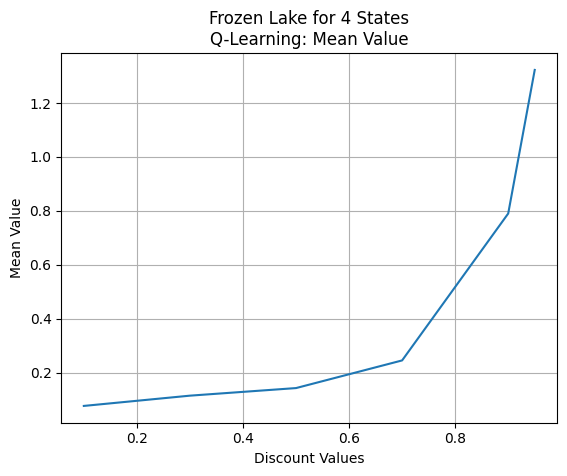

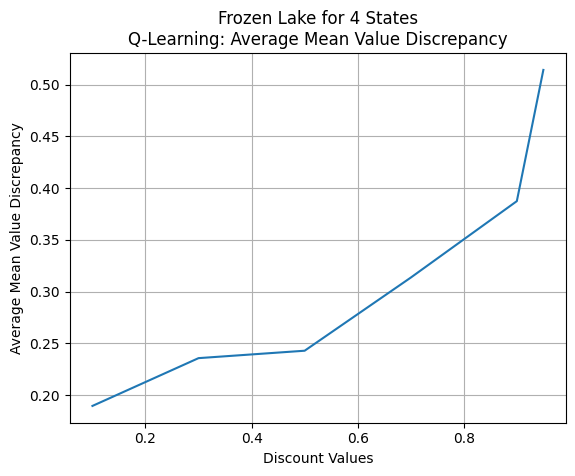

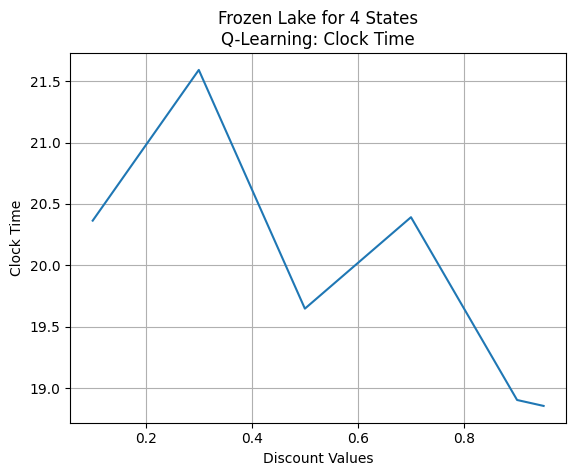

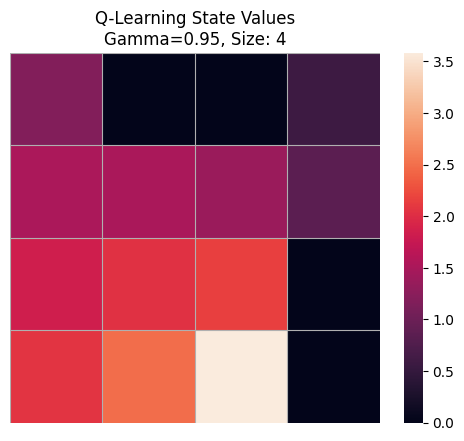

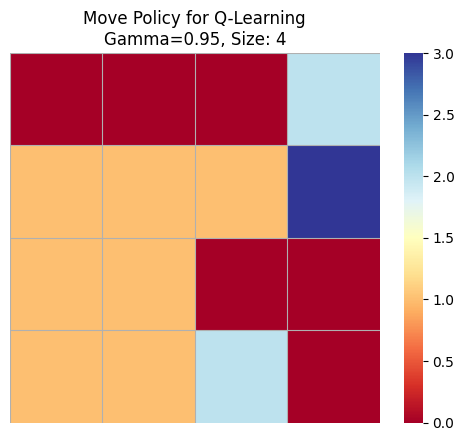

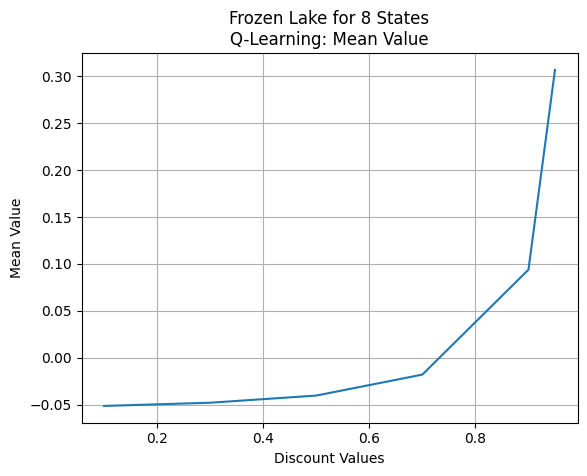

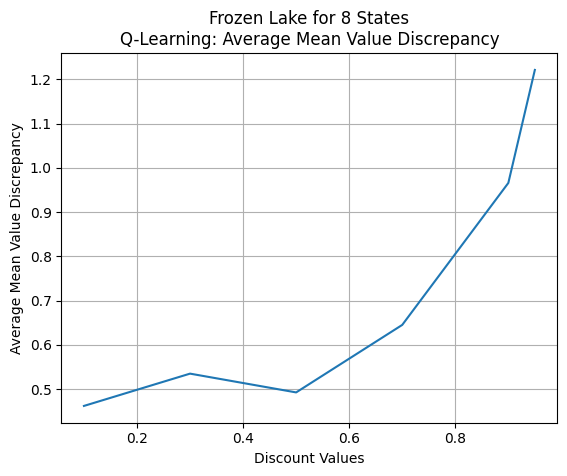

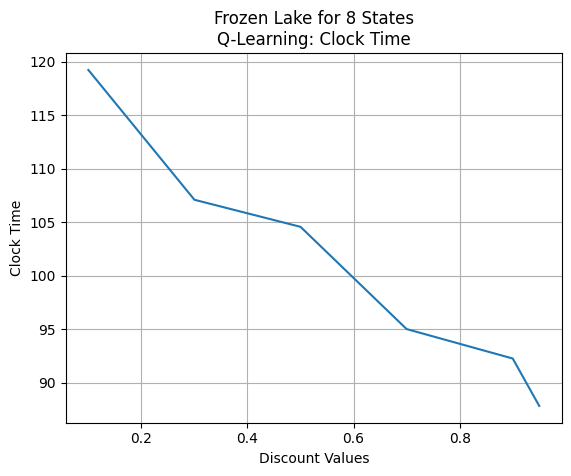

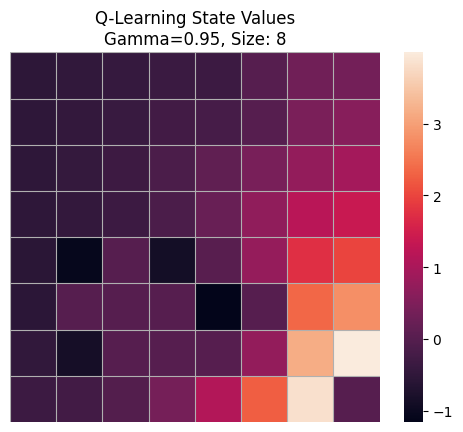

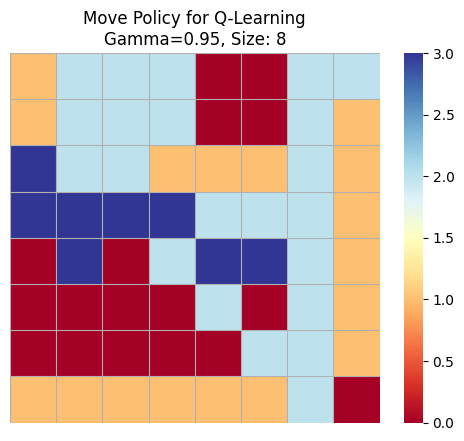

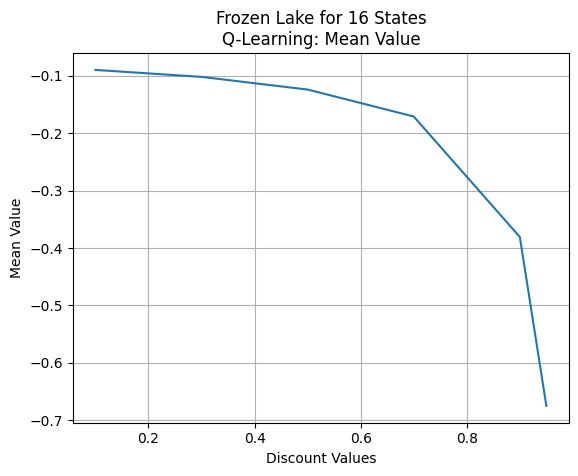

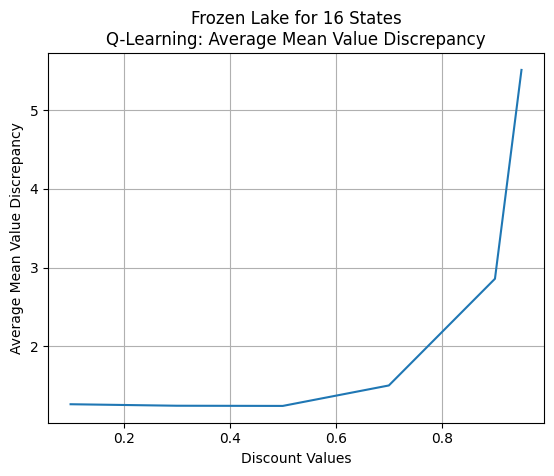

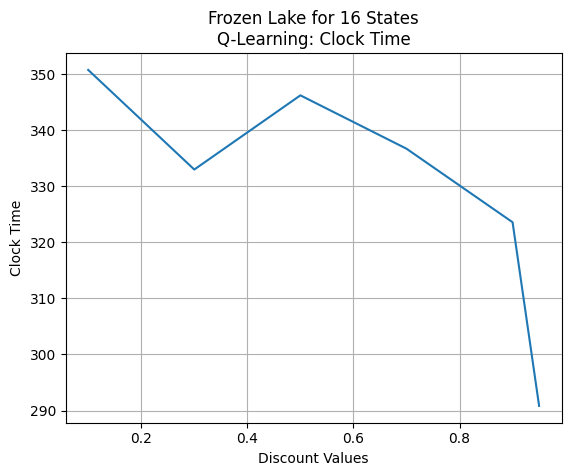

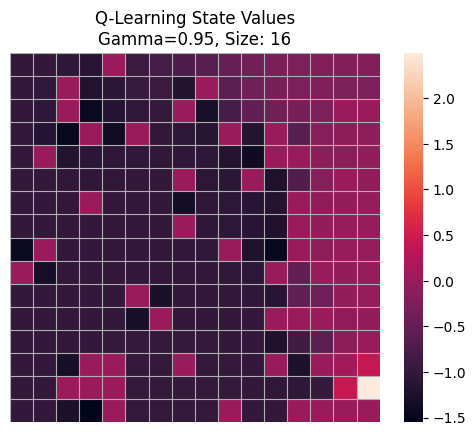

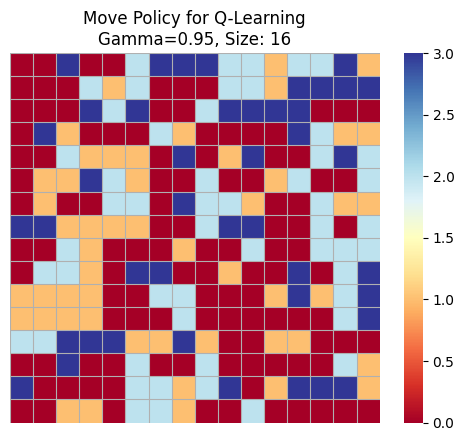

In [ ]:
for size in ql_flake_dict.keys():
    results_df = ql_flake_dict[size]
    for col in ['Mean Value','Average Mean Value Discrepancy', 'Clock Time']:
        plt.plot(results_df.index,results_df[col])
        plt.xlabel('Discount Values')
        plt.ylabel(col)
        plt.title('Frozen Lake for '+ str(size) + ' States\nQ-Learning: '+ col)
        plt.grid()
        plt.show()

    # Values Visualization for gamma 0.99
    fig, ax = plt.subplots()
    sns.heatmap(ql_flake_dict[size]['V'][0.95], square=True)
    ax.set_xticks(np.arange(0,size,1))
    ax.set_yticks(np.arange(0,size,1))
    plt.grid(which='major')
    plt.tick_params(axis='both',which='both',left=False,right=False,bottom=False,top=False,labelbottom=False,labelleft=False)
    plt.title("Q-Learning State Values\nGamma=0.95, Size: "+str(size))
    plt.show()

    # Policy Visualization for gamma 0.99
    fig, ax = plt.subplots()
    sns.heatmap(ql_flake_dict[size]['policy'][0.95], square=True, cmap ="RdYlBu")
    plt.title("Move Policy for Q-Learning\nGamma=0.95, Size: "+str(size))
    ax.set_xticks(np.arange(0,size,1))
    ax.set_yticks(np.arange(0,size,1))
    plt.tick_params(axis='both',which='both',left=False,right=False,bottom=False,top=False,labelbottom=False,labelleft=False)
    plt.grid(which='major')
    plt.show()

In [ ]:
# Q-learning
#frozen_lake = gym.make('FrozenLake-v1',is_slippery=False,desc=generate_random_map(size=16,p=0.95))
Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(frozen_lake.observation_space.n, frozen_lake.action_space.n,
                                                             init_epsilon=1,epsilon_decay_ratio=0.99,min_epsilon=0.2,
                                                             init_alpha = 0.1, alpha_decay_ratio=0.9,
                                                             gamma=0.99,n_episodes=100000)

runtime = 42.78 seconds


In [ ]:
V

array([-2.15778275e+00, -2.12002765e+00, -2.04342077e+00,  0.00000000e+00,
        0.00000000e+00, -1.38543338e+00, -1.03614320e+00, -6.69111493e-01,
       -3.99805276e-01, -2.42887671e-01, -1.79584795e-01, -6.98941520e-02,
       -5.59077862e-02, -2.02365131e-02, -1.34454923e-02, -1.23781047e-02,
       -2.11159141e+00, -2.09461982e+00, -2.04163985e+00,  0.00000000e+00,
       -1.86117257e+00, -1.68215956e+00,  0.00000000e+00, -8.56693693e-01,
       -5.47621275e-01, -3.27826827e-01,  0.00000000e+00, -2.46439253e-01,
        0.00000000e+00, -2.56905009e-02, -1.15988262e-02, -1.11758344e-02,
       -2.04528816e+00, -2.04371687e+00, -2.02620695e+00, -1.95260729e+00,
       -1.81910699e+00, -1.67390906e+00, -1.59332064e+00, -1.45162548e+00,
        0.00000000e+00, -1.41210106e-01, -6.53280295e-02, -7.24512063e-02,
        0.00000000e+00, -1.67156291e-02, -9.29175877e-03, -2.24339453e-02,
       -1.95577579e+00,  0.00000000e+00, -1.99446770e+00, -1.95597817e+00,
       -1.83737599e+00, -

Now pick your favorite reinforcement learning algorithm and use it to solve the two MDPs. How does it perform, especially in comparison to the cases above where you knew the model, rewards, and so on? What exploration strategies did you choose? Did some work better than others?